In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

sys.path.append("../../") 

from wfslib.geometry import Geometry
from wfslib.wfs import WFSData


### Загружаем данные 

In [2]:
def read_bim(path):
    with open(path, "rb") as f:
        ny = int.from_bytes(f.read(4), "little")
        nx = int.from_bytes(f.read(4), "little")
        return np.frombuffer(f.read()).reshape(ny, nx)

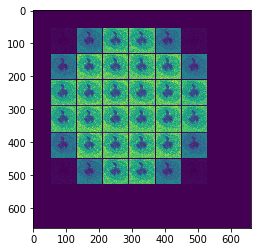

In [139]:
bim_img = read_bim("../data/bims/lsvt-z=0.bim").copy()
bim_img2 = read_bim("../data/bims/lsvt-z2=4.bim").copy()
plt.imshow(bim_img)

../..\wfslib\wfs.py:137: UserWarning: WARNING: Set the geometry for the file!
  warn("WARNING: Set the geometry for the file!", UserWarning)


{'border': 4.0, 'cell_width': 76.0, 'start_point': [182, 179]}


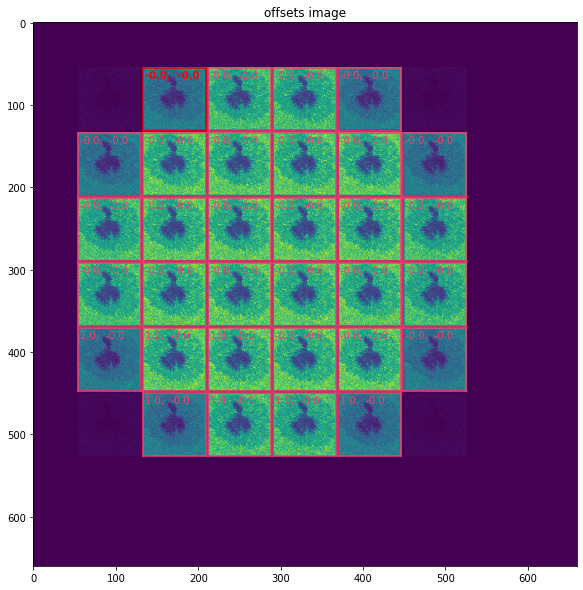

In [178]:
wfs1 = WFSData(bim_img)

p = wfs1.geometry.options
print(p)
#wfs1.geometry.set_options(shift=(-3, -3),cell_width = 75)
wfs1.geometry.set_options(shift=(-51,-49), border = 3)

wfs1.good_only = True
wfs1.reference = 0
#plt.imshow(arr[0])
wfs1.show_geometry(show_type = "offsets")


../..\wfslib\wfs.py:137: UserWarning: WARNING: Set the geometry for the file!
  warn("WARNING: Set the geometry for the file!", UserWarning)


{'border': 4.0, 'cell_width': 76.0, 'start_point': [158, 167]}


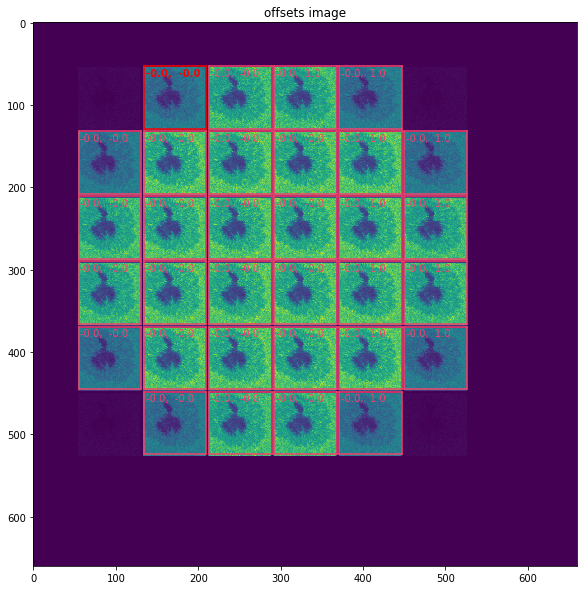

In [166]:
wfs2 = WFSData(bim_img2)

p = wfs2.geometry.options
print(p)
#wfs2.geometry.set_options(shift=(-3, -3),cell_width = 75)
wfs2.geometry.set_options(shift=(-29,-36), border = 3)
wfs2.good_only = True
wfs2.reference = 0
wfs2.show_geometry(show_type = "offsets")

### Считаем смещения (полное VS срез)

In [179]:
res = cv2.matchTemplate(wfs1[0][0].astype(np.float32),bim_img.astype(np.float32),0)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

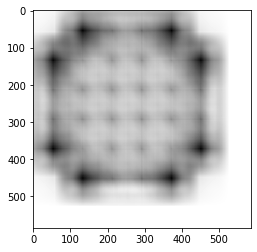

In [180]:
plt.imshow(res,cmap = 'gray')


### Считаем смещения (срез VS срез)

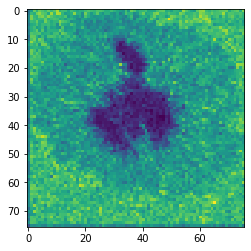

In [181]:
plt.imshow(wfs1[0][0].astype(np.float32))

### Смотрим исходные изображения

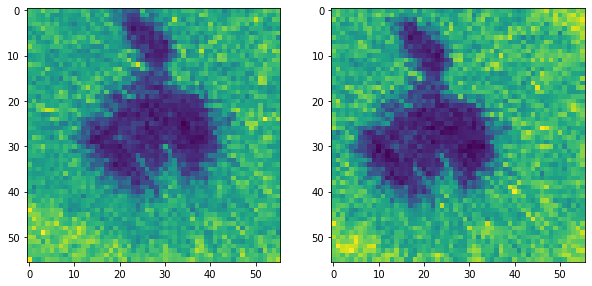

In [205]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(wfs1[0][7].astype(np.float32)[10:-10,10:-10])
plt.subplot(1,2,2)
plt.imshow(wfs2[0][7].astype(np.float32)[10:-10,10:-10])


### Правильный ответ

In [182]:
i = 10


from skimage.feature import register_translation

register_translation(wfs1[0][i].astype(np.float32), wfs2[0][i].astype(np.float32))

(array([-2.,  6.]), 0.189381272172343, 7.433167e-13)

### Считаем смещение для разных методов

In [185]:
def calc_shift(img, function):
    xc, yc = img.shape
    xc, yc = xc//2, yc//2
    xp, yp = np.where(res == function(img))    
    xp, yp = xp[0] - xc, yp[0] - yc
    return xp, yp

In [206]:
import datetime

results = {'method':[], 'time':[], 'shift':[]}
for j in range(6):    
    for i in range(15):        
        a = datetime.datetime.now()
        res = cv2.matchTemplate(wfs1[0][i].astype(np.float32), wfs2[0][i].astype(np.float32)[10:-10,10:-10],j)
        b = datetime.datetime.now()
                
        time = (a-b).microseconds
        results['time'].append(time)
        results['method'].append(j)
        if i>2:
            results['shift'].append(calc_shift(res, np.min))
        else:
            results['shift'].append(calc_shift(res, np.max))

In [208]:
print("TESTS RESULTS")
print()
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for i in range(6):
    print("Result for method %s"%methods[i])
    print("----------------------------")
    print("Time result (microseconds): ", np.mean(results['time'][i*15:(i+1)*15]))
    print("Shift result for all cells: ", results['shift'][i*15:(i+1)*15])

    
    print("\n")

TESTS RESULTS

Result for method cv2.TM_CCOEFF
----------------------------
Time result (microseconds):  955533.8666666667
Shift result for all cells:  [(10, -10), (10, -10), (10, -10), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6)]


Result for method cv2.TM_CCOEFF_NORMED
----------------------------
Time result (microseconds):  955805.8666666667
Shift result for all cells:  [(10, -10), (10, -10), (10, -10), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6), (-2, 6)]


Result for method cv2.TM_CCORR
----------------------------
Time result (microseconds):  954118.6666666666
Shift result for all cells:  [(9, 10), (9, 10), (9, 10), (-8, -10), (-8, -8), (-8, -10), (-8, -10), (-8, -10), (-7, -10), (-7, -10), (-7, -8), (-7, -10), (-8, -10), (-8, -10), (-8, -10)]


Result for method cv2.TM_CCORR_NORMED
----------------------------
Time result (microseconds):  955115.2
Shift result fo

#### ---

### Несправившийся метод

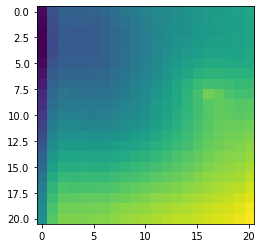

In [204]:
res = cv2.matchTemplate(wfs1[0][15].astype(np.float32), wfs2[0][15].astype(np.float32)[10:-10,10:-10],2)
plt.imshow(res)